# **Proyek Analisis Sentimen**
- Nama : Idha Kurniawati
- Email : idhakurniawati03@gmail.com
- ID Dicoding : idhakt

# Import Library

In [ ]:
# ===============================
# INSTALLASI LIBRARY
# ===============================
!pip install emoji
!pip install google-play-scraper
!pip install sastrawi
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade gensim

# ===============================
# IMPORT LIBRARY
# ===============================
## Standar & Data Handling
import csv
import pandas as pd
import numpy as np

## Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

## Sistem & Utility
import datetime as dt
import re
import string
import requests
from io import StringIO

## NLP (Natural Language Processing)
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

## Bahasa Indonesia NLP (Sastrawi)
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

## Emoji
import emoji

## Google Play Scraper
from google_play_scraper import app, reviews, Sort, reviews_all

## Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# ===============================
# KONFIGURASI AWAL
# ===============================
# Supress warning pandas chaining
pd.options.mode.chained_assignment = None

# Seed untuk reproducibility
seed = 0
np.random.seed(seed)

from gensim.models import Word2Vec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 93.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Scraping Dataset

In [ ]:
# Mengambil semua ulasan dari aplikasi dengan ID 'com.vidio.android' di Google Play Store.
scrapreview = reviews_all(
    'com.vidio.android',
    lang='id',
    country='id',
    sort=Sort.MOST_RELEVANT,
    count=12000
)

In [ ]:
# Menyimpan ulasan dalam file CSV
with open('ulasan_vidio.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Review'])
    for review in scrapreview:
        writer.writerow([review['content']])

In [ ]:
from google.colab import files
files.download('ulasan_vidio.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Loading Dataset

In [ ]:
apk_reviews_df = pd.DataFrame(scrapreview)
apk_reviews_df.shape
apk_reviews_df.head()
apk_reviews_df.to_csv('ulasan_vidio.csv', index=False)

# Membuat DataFrame dari hasil scrapreview
apk_reviews_df = pd.DataFrame(scrapreview)

# Menghitung jumlah baris dan kolom dalam DataFrame
jumlah_ulasan, jumlah_kolom = apk_reviews_df.shape

In [ ]:
print("Jumlah Ulasan  : ", jumlah_ulasan)
print("Jumlah Kolom   : ", jumlah_kolom)

Jumlah Ulasan  :  180000
Jumlah Kolom   :  11


In [ ]:
# Menampilkan lima baris pertama dari DataFrame app_reviews_df
apk_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,6ca5aa39-c6fa-448d-88a4-9eb6ea05e788,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Saya kembali memberikan bintang 1 (sebelumnya ...,1,54,6.50.8-86b0cb5048,2025-04-13 05:51:46,"Halo Kak, mohon maaf atas ketidaknyamanannya. ...",2025-04-13 06:29:45,6.50.8-86b0cb5048
1,d5defe6e-2080-4977-a0cd-0cb03a2aec13,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"untuk yg mau berlangganan,suka download videon...",1,38,6.49.14-a8e70eb5b0,2025-04-14 22:17:43,"Halo, Kak. Mohon maaf atas ketidaknyamanannya,...",2025-04-15 00:01:39,6.49.14-a8e70eb5b0
2,bc15a7d6-8ee6-4faa-981f-46b29c323588,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,saya beli paket platinum tapi di apk ( vidio )...,1,4,6.50.8-86b0cb5048,2025-04-15 17:24:44,Hallo Kak. Mohon maaf atas ketidaknyamanan nya...,2025-04-15 18:27:20,6.50.8-86b0cb5048
3,4722f612-c604-4788-b209-66f020df3cb8,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"iklan macam apa ini banyak banget,bg kalo bisa...",3,4,6.50.8-86b0cb5048,2025-04-14 23:26:27,"Halo, Kak. Mohon maaf atas ketidaknyamanannya,...",2025-04-15 00:01:49,6.50.8-86b0cb5048
4,0cd8e715-9336-4463-9a52-9e48f19268fc,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"pagi sudah debet untuk paket platinum + F1, si...",1,189,6.49.14-a8e70eb5b0,2025-04-03 06:53:04,"Halo Kak, mohon maaf atas ketidaknyamanannya. ...",2025-04-03 08:32:26,6.49.14-a8e70eb5b0


In [ ]:
# Menampilkan informasi tentang DataFrame apk_reviews_df
apk_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              180000 non-null  object        
 1   userName              180000 non-null  object        
 2   userImage             180000 non-null  object        
 3   content               179995 non-null  object        
 4   score                 180000 non-null  int64         
 5   thumbsUpCount         180000 non-null  int64         
 6   reviewCreatedVersion  126342 non-null  object        
 7   at                    180000 non-null  datetime64[ns]
 8   replyContent          158999 non-null  object        
 9   repliedAt             158999 non-null  datetime64[ns]
 10  appVersion            126342 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 15.1+ MB


In [ ]:
# Membuat DataFrame baru (clean_data_df) dengan menghapus baris yang memiliki nilai yang hilang (NaN) dari apk_reviews_df
clean_data_df = apk_reviews_df.dropna()

In [ ]:
# Menghapus baris duplikat dari DataFrame clean_data_df
clean_data_df = clean_data_df.drop_duplicates()

In [ ]:
# Menghitung jumlah baris dan kolom dalam DataFrame clean_data_df setelah menghapus duplikat
jumlah_ulasan, jumlah_kolom = clean_data_df.shape

In [ ]:
print("Jumlah Ulasan  : ", jumlah_ulasan)
print("Jumlah Kolom   : ", jumlah_kolom)

Jumlah Ulasan  :  115346
Jumlah Kolom   :  11


In [ ]:
# Menampilkan informasi tentang DataFrame clean_data_df
clean_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115346 entries, 0 to 158682
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              115346 non-null  object        
 1   userName              115346 non-null  object        
 2   userImage             115346 non-null  object        
 3   content               115346 non-null  object        
 4   score                 115346 non-null  int64         
 5   thumbsUpCount         115346 non-null  int64         
 6   reviewCreatedVersion  115346 non-null  object        
 7   at                    115346 non-null  datetime64[ns]
 8   replyContent          115346 non-null  object        
 9   repliedAt             115346 non-null  datetime64[ns]
 10  appVersion            115346 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 10.6+ MB


# Preprocessing Text

In [ ]:
def remove_emoji(text):
    return emoji.replace_emoji(text, replace='')

def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)       # Hapus mention
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)       # Hapus hashtag
    text = re.sub(r'RT\s+', '', text)                # Hapus retweet
    text = re.sub(r'http\S+', '', text)              # Hapus link
    text = re.sub(r'\d+', '', text)                  # Hapus angka
    text = re.sub(r'[^\w\s]', '', text)              # Hapus karakter non-alphanum
    text = text.replace('\n', ' ').strip()           # Hapus newline dan trim spasi
    text = text.translate(str.maketrans('', '', string.punctuation))  # Hapus tanda baca
    return remove_emoji(text)                        # Hapus emoji

def casefolding_text(text):
    return text.lower()

def tokenizing_text(text):
    return word_tokenize(text)

def filtering_text(text):
    stopwords_indo = set(stopwords.words("indonesian"))
    stopwords_eng = set(stopwords.words("english"))
    stopwords_indo.update(stopwords_eng)

    # Stopwords tambahan (kata-kata umum yang mungkin terlewat oleh NLTK)
    tambahan_stopwords = {
        "aku", "saya", "kamu", "dia", "mereka", "kita", "kami", "engkau", "anda",
        "ini", "itu", "nya", "nyaa", "di", "ke", "dari", "dengan", "dan", "atau",
        "juga", "yang", "untuk", "pada", "ada", "adalah", "ialah", "merupakan",
        "dalam", "bagi", "sebagai", "oleh", "tentang", "karena", "agar", "supaya",
        "jadi", "namun", "tetapi", "bahwa", "kalau", "kalo", "tp", "tapi", "jika",
        "meskipun", "walaupun", "sedangkan", "sementara", "sehingga", "hingga",
        "masih", "sudah", "belum", "lagi", "baru", "dulu", "telah", "akan", "mau",
        "bisa", "dapat", "harus", "mungkin", "yaitu", "yakni", "tersebut", "terjadi",
        "buat", "aja", "cuma", "doang", "dong", "donk", "deh", "lho", "lohh", "loh",
        "nih", "tuh", "ya", "yaa", "iyaa", "yah", "yaudah", "ywdh", "gitu", "gini",
        "kok", "kan", "lah", "sih", "pun", "eh", "hmm", "btw", "wkwk", "wkwkwk",
        "haha", "hehe", "mantul", "mantap", "oke", "ok", "okey", "sip", "yoi", "gt",
        "nice", "good", "thanks", "thankyou", "thanku", "tq", "pls", "please",
        "makasih", "makasi", "terimakasih", "gw", "gua", "gue", "lu", "loe", "lo",
        "bro", "cuy", "sis", "bang", "bg", "mas", "mbak", "om", "tante", "bruh",
        "gak", "ga", "gk", "ngk", "nggak", "ngga", "engk", "engga", "tdk", "td",
        "dr", "dgn", "krn", "sm", "jd", "cm", "cmn", "dmn", "ntar", "nt", "trus",
        "terus", "besok", "kemarin", "sekarang", "hari", "kemana", "kenapa",
        "siapa", "apa", "bagaimana", "dimana", "ngapain", "mikir", "nanya",
        "dah", "udh", "udah", "woi", "woii", "woy", "gaa", "kah", "ampun", "bgt",
        "dikit", "banget", "parah", "katanya", "sama", "padahal", "yg", "kapan",
        "emang", "kayak", "kayaknya", "ngerti", "bener", "serius", "bg", "cok",
        "coy", "coi"
        }
    stopwords_indo.update(tambahan_stopwords)

    return [txt for txt in text if txt not in stopwords_indo]

slangwords_vidio = {
    "@": "di", "abis": "habis", "wts": "jual", "wtb": "beli", "wtt": "tukar", "masi": "masih",
    "bgt": "banget", "banget": "sekali", "maks": "maksimal", "ga": "tidak", "gak": "tidak",
    "ngga": "tidak", "nggak": "tidak", "engga": "tidak", "no": "tidak", "tdk": "tidak",
    "td": "tadi", "udh": "sudah", "sdh": "sudah", "blm": "belum", "cm": "cuma", "cmn": "cuma",
    "cuma": "hanya", "aja": "saja", "doang": "saja", "yg": "yang", "klo": "kalau", "kl": "kalau",
    "klu": "kalau", "tp": "tapi", "jg": "juga", "sm": "sama", "sy": "saya", "gw": "saya",
    "gua": "saya", "ane": "saya", "lu": "kamu", "loe": "kamu", "km": "kamu", "u": "kamu",
    "kmu": "kamu", "trs": "terus", "trus": "terus", "gt": "begitu", "lg": "lagi", "pd": "pada",
    "krn": "karena", "skrg": "sekarang", "plis": "tolong", "pls": "tolong", "gpp": "tidak apa-apa",
    "makasih": "terima kasih", "makasi": "terima kasih", "makash": "terima kasih", "thx": "terima kasih",
    "thankyou": "terima kasih", "thanku": "terima kasih", "tq": "terima kasih", "ywdh": "ya sudah",
    "yaudah": "ya sudah", "btw": "ngomong-ngomong", "y": "ya", "ok": "oke", "oke": "oke",
    "okey": "oke", "sip": "baik", "nice": "baik", "good": "baik", "mantap": "baik", "mantul": "mantap betul",
    }

def fix_slangwords(text):
     return ' '.join([slangwords_vidio.get(word.lower(), word) for word in text.split()])

def stemming_text(text):
    stemmer = StemmerFactory().create_stemmer()
    return ' '.join([stemmer.stem(word) for word in text.split()])

def to_sentence(list_words):
    return ' '.join(list_words)

In [ ]:
clean_data_df['text_clean']       = clean_data_df['content'].apply(clean_text) # Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_data_df['text_casefolding'] = clean_data_df['text_clean'].apply(casefolding_text) # Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefolding'
clean_data_df['text_slangwords']  = clean_data_df['text_casefolding'].apply(fix_slangwords) # Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_data_df['text_tokenizing']  = clean_data_df['text_slangwords'].apply(tokenizing_text) # Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizing'
clean_data_df['text_stopword']    = clean_data_df['text_tokenizing'].apply(filtering_text) # Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_data_df['final_text']        = clean_data_df['text_stopword'].apply(to_sentence) # Menggabungkan token-token menjadi kalimat dan menyimpannya di 'final_text'

In [ ]:
clean_data_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefolding,text_slangwords,text_tokenizing,text_stopword,final_text
0,6ca5aa39-c6fa-448d-88a4-9eb6ea05e788,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Saya kembali memberikan bintang 1 (sebelumnya ...,1,54,6.50.8-86b0cb5048,2025-04-13 05:51:46,"Halo Kak, mohon maaf atas ketidaknyamanannya. ...",2025-04-13 06:29:45,6.50.8-86b0cb5048,Saya kembali memberikan bintang sebelumnya pe...,saya kembali memberikan bintang sebelumnya pe...,saya kembali memberikan bintang sebelumnya per...,"[saya, kembali, memberikan, bintang, sebelumny...","[bintang, bintang, tertipu, memilih, paket, ta...",bintang bintang tertipu memilih paket tabel in...
1,d5defe6e-2080-4977-a0cd-0cb03a2aec13,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"untuk yg mau berlangganan,suka download videon...",1,38,6.49.14-a8e70eb5b0,2025-04-14 22:17:43,"Halo, Kak. Mohon maaf atas ketidaknyamanannya,...",2025-04-15 00:01:39,6.49.14-a8e70eb5b0,untuk yg mau berlangganansuka download videony...,untuk yg mau berlangganansuka download videony...,untuk yang mau berlangganansuka download video...,"[untuk, yang, mau, berlangganansuka, download,...","[berlangganansuka, download, videonya, nonton,...",berlangganansuka download videonya nonton beri...
2,bc15a7d6-8ee6-4faa-981f-46b29c323588,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,saya beli paket platinum tapi di apk ( vidio )...,1,4,6.50.8-86b0cb5048,2025-04-15 17:24:44,Hallo Kak. Mohon maaf atas ketidaknyamanan nya...,2025-04-15 18:27:20,6.50.8-86b0cb5048,saya beli paket platinum tapi di apk vidio n...,saya beli paket platinum tapi di apk vidio n...,saya beli paket platinum tapi di apk vidio nya...,"[saya, beli, paket, platinum, tapi, di, apk, v...","[beli, paket, platinum, apk, vidio, bayar, pdh...",beli paket platinum apk vidio bayar pdhl bayar...
3,4722f612-c604-4788-b209-66f020df3cb8,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"iklan macam apa ini banyak banget,bg kalo bisa...",3,4,6.50.8-86b0cb5048,2025-04-14 23:26:27,"Halo, Kak. Mohon maaf atas ketidaknyamanannya,...",2025-04-15 00:01:49,6.50.8-86b0cb5048,iklan macam apa ini banyak bangetbg kalo bisa ...,iklan macam apa ini banyak bangetbg kalo bisa ...,iklan macam apa ini banyak bangetbg kalo bisa ...,"[iklan, macam, apa, ini, banyak, bangetbg, kal...","[iklan, bangetbg, iklanya, dikurangi, boros, k...",iklan bangetbg iklanya dikurangi boros kuota b...
4,0cd8e715-9336-4463-9a52-9e48f19268fc,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"pagi sudah debet untuk paket platinum + F1, si...",1,189,6.49.14-a8e70eb5b0,2025-04-03 06:53:04,"Halo Kak, mohon maaf atas ketidaknyamanannya. ...",2025-04-03 08:32:26,6.49.14-a8e70eb5b0,pagi sudah debet untuk paket platinum F siang...,pagi sudah debet untuk paket platinum f siang...,pagi sudah debet untuk paket platinum f siangn...,"[pagi, sudah, debet, untuk, paket, platinum, f...","[pagi, debet, paket, platinum, f, siangnya, de...",pagi debet paket platinum f siangnya debet pak...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158666,b803a091-780c-4b9d-a03e-9fc257409b1e,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Knp engk bs donlwod,5,0,1.3,2015-07-29 16:03:33,Saat ini kami belum menyediakan feature downlo...,2015-09-30 04:40:05,1.3,Knp engk bs donlwod,knp engk bs donlwod,knp engk bs donlwod,"[knp, engk, bs, donlwod]","[knp, bs, donlwod]",knp bs donlwod
158671,716d6d01-dd48-4888-823c-ae0df58f47d4,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Kok video nya buffering melulu ya? Apa cmn hp ...,2,0,1.2,2015-06-17 00:54:20,"Hi Dewa Nasution, thanks inputnya, setelah kam...",2015-09-30 07:21:15,1.2,Kok video nya buffering melulu ya Apa cmn hp s...,kok video nya buffering melulu ya apa cmn hp s...,kok video nya buffering melulu ya apa cuma hp ...,

In [ ]:
print("\nHasil Preprocessing:")
print(clean_data_df[['content', 'final_text']].head())


Hasil Preprocessing:
                                             content  \
0  Saya kembali memberikan bintang 1 (sebelumnya ...   
1  untuk yg mau berlangganan,suka download videon...   
2  saya beli paket platinum tapi di apk ( vidio )...   
3  iklan macam apa ini banyak banget,bg kalo bisa...   
4  pagi sudah debet untuk paket platinum + F1, si...   

                                          final_text  
0  bintang bintang tertipu memilih paket tabel in...  
1  berlangganansuka download videonya nonton beri...  
2  beli paket platinum apk vidio bayar pdhl bayar...  
3  iklan bangetbg iklanya dikurangi boros kuota b...  
4  pagi debet paket platinum f siangnya debet pak...  


# Pelabelan

In [ ]:
# Mengambil data lexicon kata positif dari repositori GitHub
lexicon_positive = {}

url_positive = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv'
response = requests.get(url_positive)
# Melakukan HTTP request untuk mengunduh file CSV berisi kata-kata positif

if response.status_code == 200:
    # Jika file berhasil diambil dari URL
    csv_data = csv.reader(StringIO(response.text), delimiter=',')
    # Mengubah isi respon menjadi format CSV dengan pemisah koma

    for entry in csv_data:
        # Iterasi setiap entri dalam data CSV
        lexicon_positive[entry[0]] = int(entry[1])
        # Simpan kata dan nilainya ke dalam dictionary lexicon_positive
else:
    print("Gagal mengambil data lexicon positif")


# Mengambil data lexicon kata negatif dari repositori GitHub
lexicon_negative = {}

url_negative = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv'
response = requests.get(url_negative)
# Melakukan HTTP request untuk mengunduh file CSV berisi kata-kata negatif

if response.status_code == 200:
    # Jika pengambilan data berhasil
    csv_data = csv.reader(StringIO(response.text), delimiter=',')
    # Mengonversi respon teks menjadi objek pembaca CSV

    for entry in csv_data:
        # Proses setiap baris dalam file CSV
        lexicon_negative[entry[0]] = int(entry[1])
        # Menambahkan data kata negatif dan nilainya ke dictionary lexicon_negative
else:
    print("Gagal mengambil data lexicon negatif")

In [ ]:
def sentiment_analysis_lexicon_indo(text):
    score = 0
    # Mulai dari skor 0

    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]

    for word in text:
        if word in lexicon_negative:
            score += lexicon_negative[word]

    # Klasifikasi berdasarkan skor akhir
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [ ]:
# Asumsikan clean_data_df['text_stopword'] adalah list token yang sudah dibersihkan
results = clean_data_df['text_stopword'].apply(sentiment_analysis_lexicon_indo)

# Pisahkan skor dan label
results = list(zip(*results))
clean_data_df['polarity_score'] = results[0]
clean_data_df['polarity'] = results[1]

In [ ]:
# Memastikan ada minimal tiga kelas
print("\nDistribusi Label Awal:")
print(clean_data_df['polarity'].value_counts())


Distribusi Label Awal:
polarity
neutral     48241
negative    42874
positive    24231
Name: count, dtype: int64


In [ ]:
if len(clean_data_df['polarity'].unique()) < 3:
    print("\nPERHATIAN: Dataset hanya memiliki {} kelas. Syarat minimal 3 kelas tidak terpenuhi.".format(len(clean_data_df['polarity'].unique())))
else:
    print("\nDataset memiliki {} kelas. Syarat minimal 3 kelas terpenuhi.".format(len(clean_data_df['polarity'].unique())))


Dataset memiliki 3 kelas. Syarat minimal 3 kelas terpenuhi.


In [ ]:
clean_data_df.to_csv('labeling_data.csv', index=False)

In [ ]:
"""clean_data_df.to_csv('labeling_data.csv', index=False)
files.download('labeling_data.csv')"""

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Visualisasi

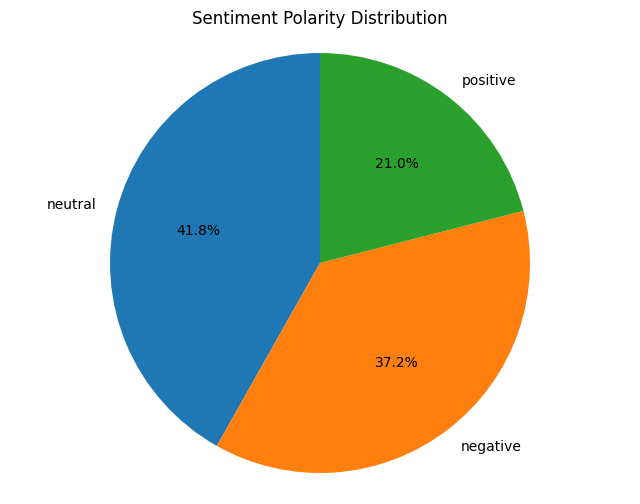

In [ ]:
polarity_counts = clean_data_df['polarity'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Polarity Distribution')
plt.axis('equal')
plt.show()


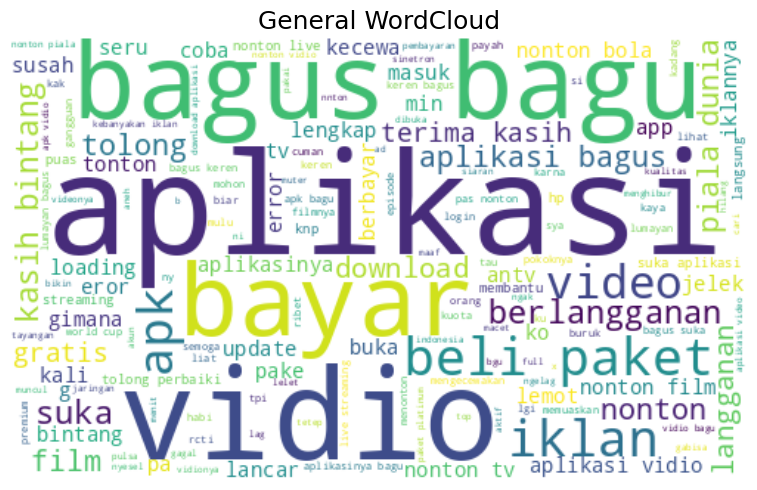

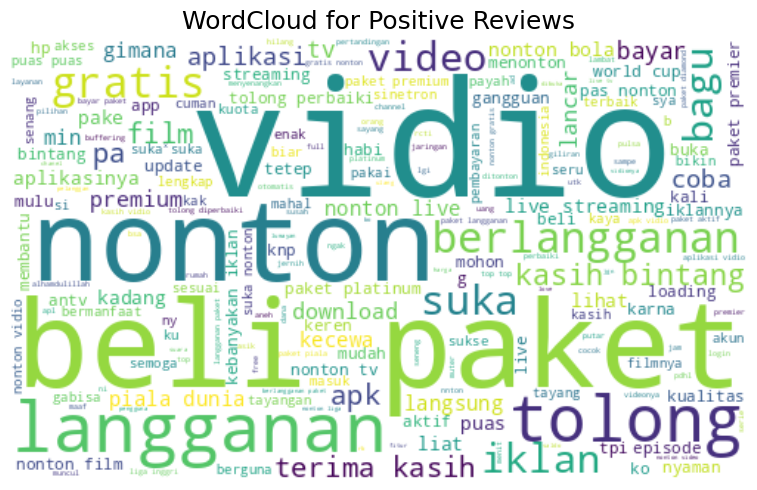

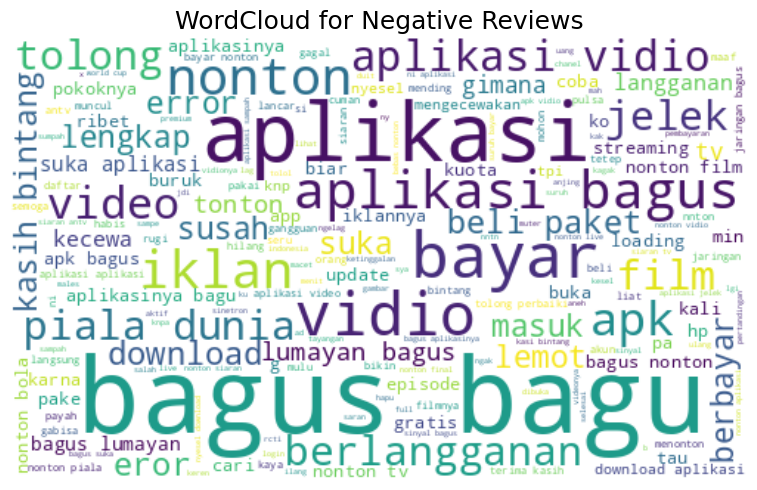

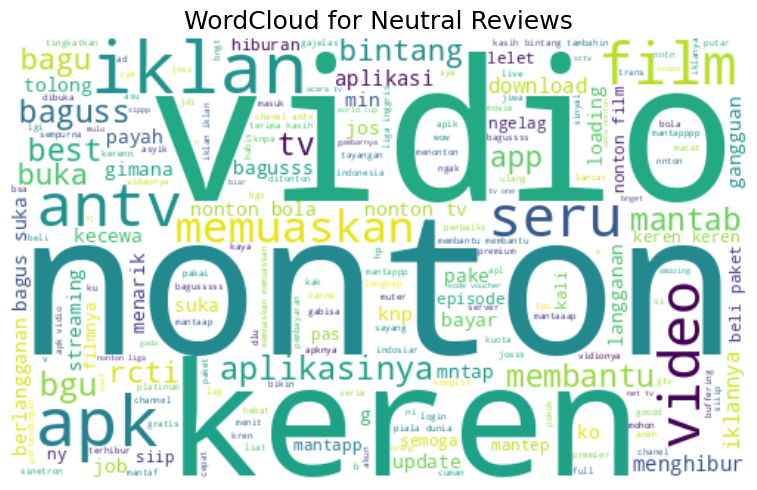

In [ ]:
# Gabungkan teks berdasarkan kategori sentimen
text_all = ' '.join(review for review in clean_data_df['final_text'])
text_positive = ' '.join(review for review in clean_data_df[clean_data_df['polarity'] == 'positive']['final_text'])
text_negative = ' '.join(review for review in clean_data_df[clean_data_df['polarity'] == 'negative']['final_text'])
text_neutral = ' '.join(review for review in clean_data_df[clean_data_df['polarity'] == 'neutral']['final_text'])

# Fungsi untuk generate dan tampilkan WordCloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=500, height=300, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=18)
    plt.tight_layout()
    plt.show()

# Tampilkan WordClouds satu per satu
generate_wordcloud(text_all, 'General WordCloud')
generate_wordcloud(text_positive, 'WordCloud for Positive Reviews')
generate_wordcloud(text_negative, 'WordCloud for Negative Reviews')
generate_wordcloud(text_neutral, 'WordCloud for Neutral Reviews')